In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from functools import reduce

from qiskit import QuantumCircuit, transpile, BasicAer, Aer, IBMQ
from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, PauliFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit.algorithms.state_fidelities import ComputeUncompute

from qiskit.primitives import BackendEstimator, BackendSampler, Sampler
from qiskit.quantum_info import Pauli
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

In [34]:
SEED = 123
qasm_sim = AerSimulator()

# Dataset

In [35]:
n_samples=50
a = 2
b = 2
x1, _ = datasets.make_gaussian_quantiles(mean = [-a,-a], cov=2.0, n_samples=n_samples, n_features=2, n_classes=2, random_state=SEED)
x2, _ = datasets.make_gaussian_quantiles(mean = [b,b], cov=4.0, n_samples=n_samples, n_features=2, n_classes=2, random_state=SEED)

y1 = np.array([0 for i in range(n_samples)])
y2 = np.array([1 for i in range(n_samples)])

x = np.concatenate((x1, x2))
y = np.concatenate((y1, y2))
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Train set size: 80
Test set size:  20


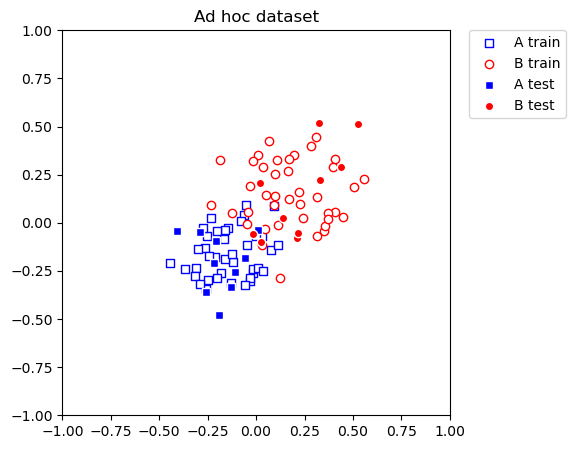

In [36]:
# Normalizatin
x[:,0] = x[:,0] / (np.max(x[:,0]) - np.min(x[:,0]))
x[:,1] = x[:,1] / (np.max(x[:,1]) - np.min(x[:,1]))

num_classes = 2
num_features = 2
adhoc_dimension = 2
x_blue = x[y==0]
x_red = x[y==1]


test_ratio = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=SEED, stratify=y)

print(f"Train set size: {len(x_train)}")
print(f"Test set size:  {len(x_test)}")
def plot_features(ax, features, labels, class_label, marker, face, edge, label):
    # A train plot
    ax.scatter(
        # x coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 0],
        # y coordinate of labels where class is class_label
        features[np.where(labels[:] == class_label), 1],
        marker=marker,
        facecolors=face,
        edgecolors=edge,
        label=label,
    )


def plot_dataset(x_train, y_train,x_test, y_test):

# train_features, train_labels, test_features, test_labels
    plt.figure(figsize=(5, 5))
    plt.ylim(-1, 1)
    plt.xlim(-1, 1)
    # plt.imshow(
    #     np.asmatrix(adhoc_total).T,
    #     interpolation="nearest",
    #     origin="lower",
    #     cmap="RdBu",
    #     extent=[0, 2 * np.pi, 0, 2 * np.pi],
    # )
 # A train plot
    plot_features(plt, x_train,  y_train, 0, "s", "w", "b", "A train")

    # B train plot
    plot_features(plt, x_train,  y_train, 1, "o", "w", "r", "B train")

    # A test plot
    plot_features(plt, x_test, y_test, 0, "s", "b", "w", "A test")

    # B test plot
    plot_features(plt, x_test, y_test, 1, "o", "r", "w", "B test")

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
    plt.title("Ad hoc dataset")

    plt.show()


plot_dataset(x_train, y_train,x_test, y_test)

# Data embedding circuits

In [ ]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(num_features, 2, 'linear')
input_params = fmap_zz.parameters
fmap_zz.decompose().draw('mpl', scale=0.7)

sampler = Sampler()

fidelity =ComputeUncompute(sampler=sampler)



def data_map_eq8(x: np.ndarray) -> float:
   
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: np.pi*(m * n), x)
    return coeff

def data_map_eq9(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: (np.pi/2)*(m * n), 1 - x)
    return coeff

def data_map_eq10(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: np.pi*np.exp(((m - n)*(m - n))/8), x)
    return coeff

def data_map_eq11(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: (np.pi/3)*(m * n), 1/(np.cos(x)))
    return coeff

def data_map_eq12(x: np.ndarray) -> float:
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: np.pi*(m * n), np.cos(x))
    return coeff

qfm_default = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full')
qfm_eq8 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq8)
qfm_eq9 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq9)
qfm_eq10 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq10)
qfm_eq11 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq11)
qfm_eq12 = PauliFeatureMap(feature_dimension=2, 
                                    paulis = ['ZI','IZ','ZZ'],
                                 reps=2, entanglement='full', data_map_func=data_map_eq12)

qcomp_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,
                                seed_simulator=SEED, seed_transpiler=SEED)

qkern_default = FidelityQuantumKernel(fidelity=fidelity, feature_map=qfm_default)
qkern_eq8 = FidelityQuantumKernel(fidelity=fidelity,feature_map=qfm_eq8)
qkern_eq9 = FidelityQuantumKernel(fidelity=fidelity,feature_map=qfm_eq9)
qkern_eq10 = FidelityQuantumKernel(fidelity=fidelity,feature_map=qfm_eq10)
qkern_eq11 = FidelityQuantumKernel(fidelity=fidelity,feature_map=qfm_eq11)
qkern_eq12 = FidelityQuantumKernel(fidelity=fidelity,feature_map=qfm_eq12)

qkern_default_matrix = qkern_default.evaluate(x_vec=x)
qkern_eq8_matrix = qkern_eq8.evaluate(x_vec=x)
qkern_eq9_matrix = qkern_eq9.evaluate(x_vec=x)
qkern_eq10_matrix = qkern_eq10.evaluate(x_vec=x)
qkern_eq11_matrix = qkern_eq11.evaluate(x_vec=x)
qkern_eq12_matrix = qkern_eq12.evaluate(x_vec=x)

C:\Users\nadin\AppData\Local\Temp\ipykernel_16804\2421428052.py:54: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  qcomp_backend = QuantumInstance(BasicAer.get_backend('qasm_simulator'), shots=1024,


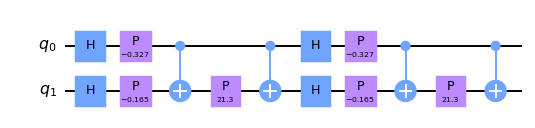

In [45]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x[0])}).decompose().draw('mpl', scale=0.7)